In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler

%matplotlib inline

In [22]:
df = pd.read_csv('metadata.csv')

In [23]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Drop column: 'Path'
    df = df.drop(columns=['Path'])
    # Drop column: 'Other_species30'
    df = df.drop(columns=['Other_species30'])
    # Drop column: 'Other_species28'
    df = df.drop(columns=['Other_species28'])
    # Drop column: 'Other_species29'
    df = df.drop(columns=['Other_species29'])
    # Drop column: 'Other_species27'
    df = df.drop(columns=['Other_species27'])
    # Drop column: 'Other_species26'
    df = df.drop(columns=['Other_species26'])
    # Drop column: 'Other_species25'
    df = df.drop(columns=['Other_species25'])
    # Drop column: 'Other_species24'
    df = df.drop(columns=['Other_species24'])
    # Drop column: 'Other_species23'
    df = df.drop(columns=['Other_species23'])
    # Drop column: 'Remarks'
    df = df.drop(columns=['Remarks'])
    # Drop column: 'Spectrogram_full'
    df = df.drop(columns=['Spectrogram_full'])
    # Drop column: 'Spectrogram_large'
    df = df.drop(columns=['Spectrogram_large'])
    # Drop column: 'Spectrogram_med'
    df = df.drop(columns=['Spectrogram_med'])
    # Drop column: 'Spectrogram_small'
    df = df.drop(columns=['Spectrogram_small'])
    # Drop column: 'file.name'
    df = df.drop(columns=['file.name'])
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Replace all instances of "?" with "" in column: 'Altitude'
    df['Altitude'] = df['Altitude'].replace(to_replace='?', value=np.nan)
    # Replace all instances of "" with "" in column: 'Time'
    df['Time'] = df['Time'].replace(to_replace='?', value=np.nan)
    # Ensure 'Altitude' and are numeric, coerce errors to NaN
    df['Altitude'] = pd.to_numeric(df['Altitude'], errors='coerce')
    # Drop rows with missing data in column: 'Date'
    df = df.dropna(subset=['Date','Altitude'])
    # Drop column: 'Url'
    df = df.drop(columns=['Url'])
    # Drop column: 'License'
    df = df.drop(columns=['License'])
    # Drop column: 'Audio_file'
    df = df.drop(columns=['Audio_file'])
    # Capitalize the first character in column: 'Locality'
    df['Locality'] = df['Locality'].str.title()
    return df

df_clean = clean_data(df.copy())
df = df_clean


In [24]:
# Convert Length from "minutes:seconds" format to total seconds
def convert_to_seconds(length):
    try:
        minutes, seconds = map(int, length.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return np.nan  # Handle invalid formats as NaN
    
df['Length_seconds'] = df['Length'].apply(convert_to_seconds)

df['Time'] = df['Time'].astype(str)

def convert_time_to_minutes(time_str):
    try:
        if ':' in time_str:
            hours, minutes = map(int, time_str.split(':'))
            return hours * 60 + minutes
        else:
            return np.nan  # Return NaN if the format is not as expected
    except (ValueError, AttributeError):
        return np.nan

df['Time_minutes'] = df['Time'].apply(convert_time_to_minutes)

In [25]:
# Preparing data for quality prediction

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


features = ['Species', 'Latitude', 'Longitude', 'Altitude']
df_clean = df[features].dropna()

# Encode 'Species' as numeric
label_encoder = LabelEncoder()
df_clean['Species_encoded'] = label_encoder.fit_transform(df_clean['Species'])


# Anomaly detection
anomaly_features = ['Latitude', 'Longitude', 'Altitude']
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_clean['Anomaly_Score'] = iso_forest.fit_predict(df_clean[anomaly_features])


# Keep only normal data (Anomaly_Score == 1)
df_clean = df_clean[df_clean['Anomaly_Score'] == 1].drop(columns=['Anomaly_Score'])

scaler = StandardScaler()
df_clean[['Latitude', 'Longitude']] = scaler.fit_transform(df_clean[['Latitude', 'Longitude']])


X = df_clean[['Species_encoded', 'Latitude', 'Longitude']]
y = df_clean['Altitude']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


XGBoost Regressor Performance:
Root Mean Squared Error (RMSE): 102.26
R² Score: 0.72


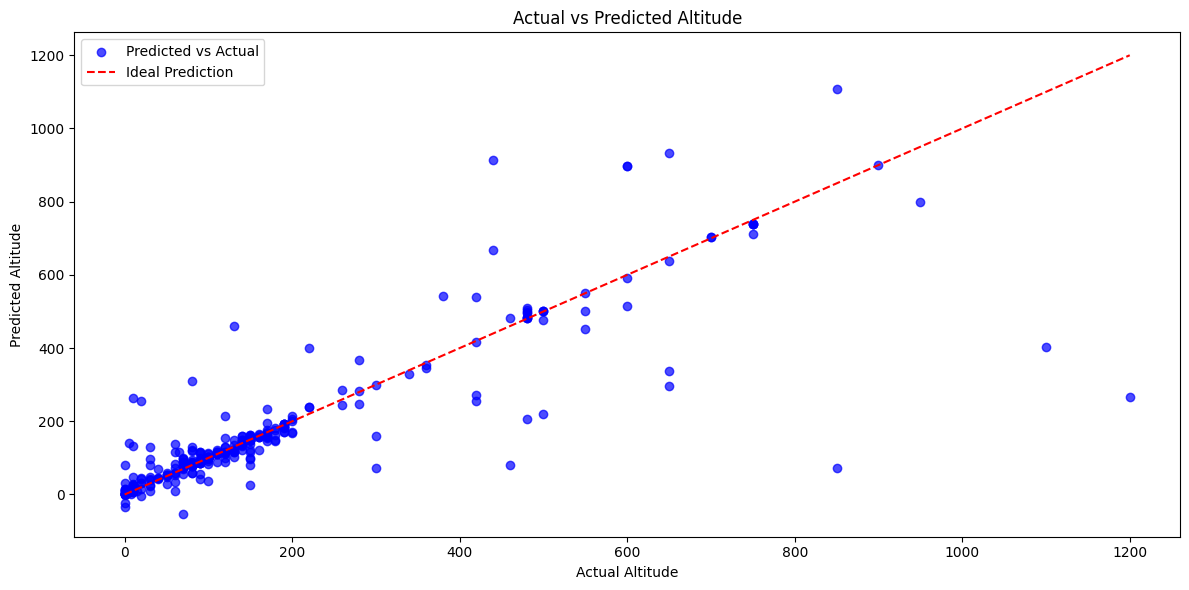

C:\Users\Grzegorz\AppData\Local\Temp\ipykernel_22632\806917753.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='viridis')


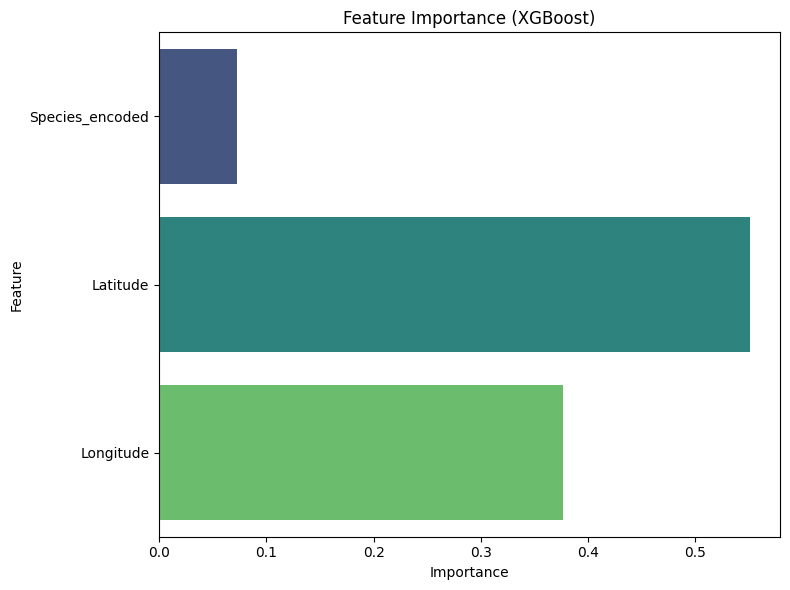

In [32]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Dictionary to store performance metrics
results = {
    'Model': [],
    'RMSE': [],
    'R2 Score': []
}


# Train an XGBoost classifier
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("XGBoost Regressor Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Visualization: Actual vs Predicted Altitude
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted Altitude')
plt.xlabel('Actual Altitude')
plt.ylabel('Predicted Altitude')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization: Feature Importances for XGBoost
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 6))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='viridis')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# For comparison later
results['Model'].append("XGBRegressor")
results['RMSE'].append(rmse)
results['R2 Score'].append(r2)
y_pred_xgb=y_pred


In [27]:
mean_alt = df_clean['Altitude'].mean()
std_alt = df_clean['Altitude'].std()
print(f"Mean Altitude: {mean_alt}")
print(f"Standard Deviation of Altitude: {std_alt}")

baseline_pred = y_test.mean()
baseline_rmse = np.sqrt(mean_squared_error(y_test, [baseline_pred] * len(y_test)))
print(f"Baseline RMSE: {baseline_rmse}")




Mean Altitude: 164.7281767955801
Standard Deviation of Altitude: 189.70059949233698
Baseline RMSE: 192.5846819424459


Random Forest Regressor Performance:
Root Mean Squared Error (RMSE): 98.32
R² Score: 0.74


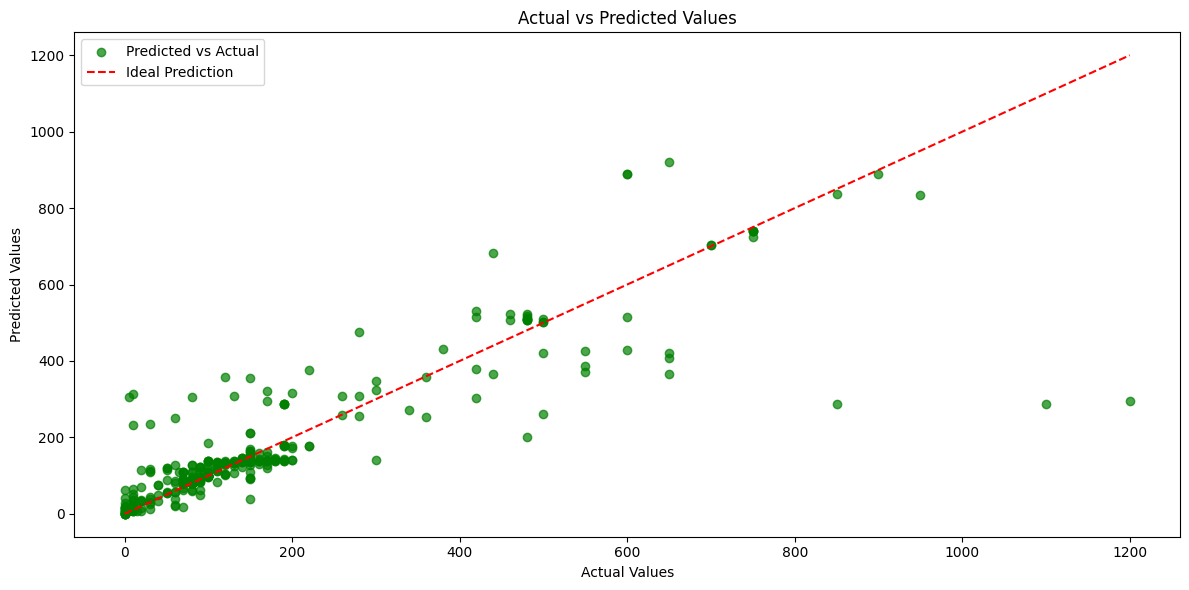

C:\Users\Grzegorz\AppData\Local\Temp\ipykernel_22632\2232445306.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')


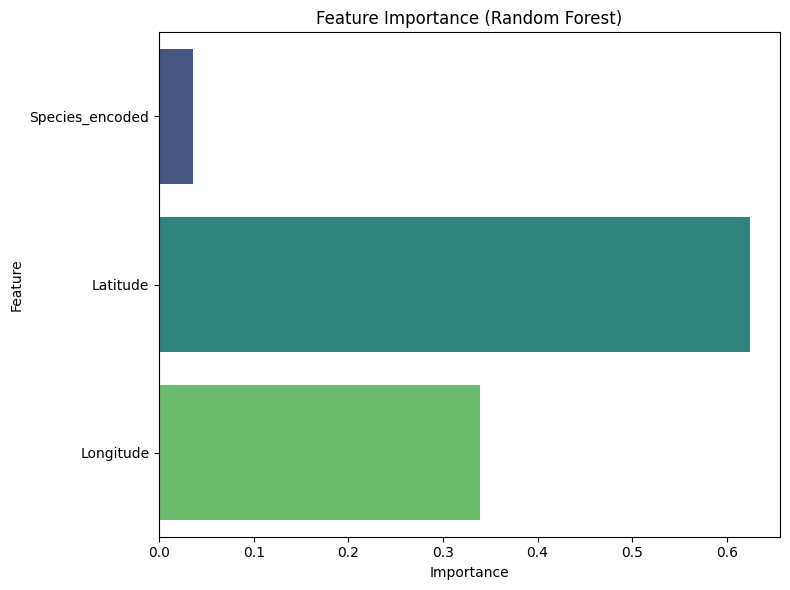

In [33]:
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(
    n_estimators=200,   
    max_depth=8,       
    random_state=42,    
    n_jobs=-1           
)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Random Forest Regressor Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Visualization: Actual vs Predicted Altitude
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='green', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization: Feature Importances for Random Forest
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 6))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# For comparison later
results['Model'].append("RandomForest")
results['RMSE'].append(rmse)
results['R2 Score'].append(r2)
y_pred_rf=y_pred

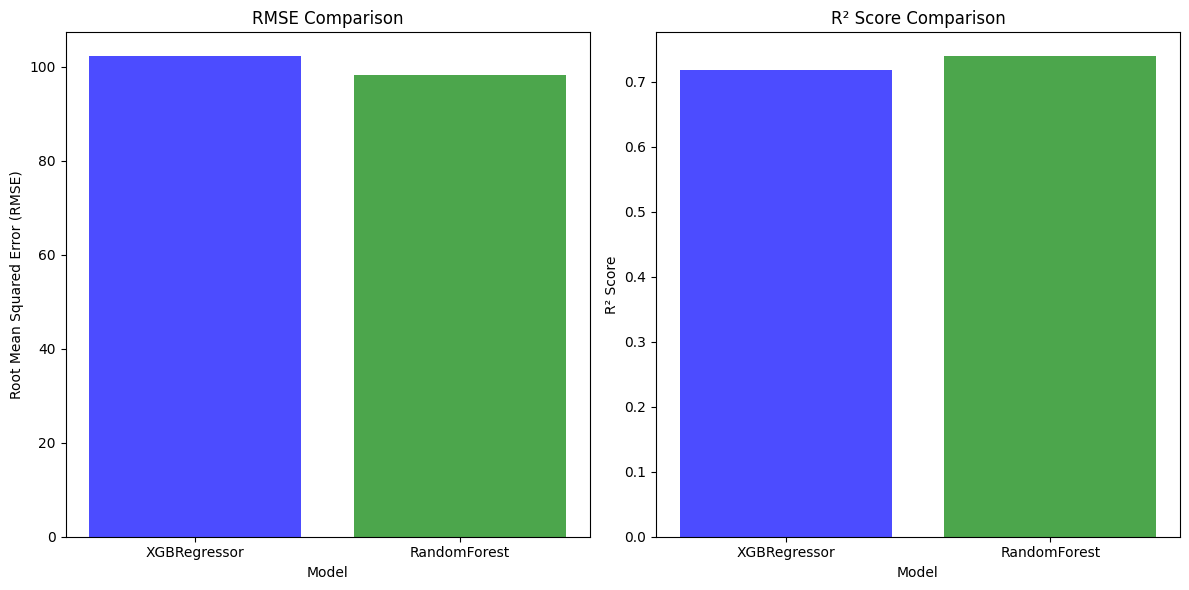

In [29]:

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# RMSE comparison
axes[0].bar(results['Model'], results['RMSE'], color=['blue', 'green'], alpha=0.7)
axes[0].set_title('RMSE Comparison')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].set_xlabel('Model')

# R² Score comparison
axes[1].bar(results['Model'], results['R2 Score'], color=['blue', 'green'], alpha=0.7)
axes[1].set_title('R² Score Comparison')
axes[1].set_ylabel('R² Score')
axes[1].set_xlabel('Model')

# Adjust layout and show
plt.tight_layout()
plt.show()

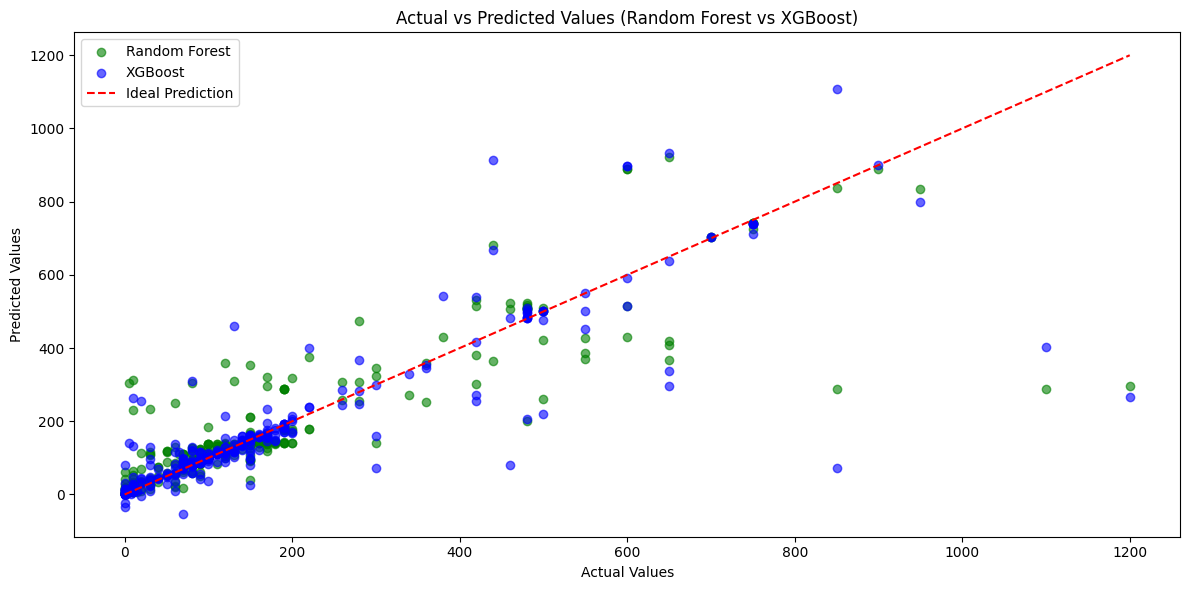

In [34]:
plt.figure(figsize=(12, 6))

# Scatter plot for Random Forest predictions
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green', label='Random Forest')

# Scatter plot for XGBoost predictions
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='blue', label='XGBoost')

# Ideal prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')

# Graph details
plt.title('Actual vs Predicted Values (Random Forest vs XGBoost)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()